<a href="https://colab.research.google.com/github/10acad-group3/speech_recognition/blob/elias/3_0_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition


## Imports

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU.')
else:
  print(gpu_info)

Wed Aug 11 14:20:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1266071071475033774
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11344216064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13826450791053856117
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
import os
import sys
import cv2
import pickle

import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio

import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.graph_objects as go
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard

In [4]:
sns.set()
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [5]:
from clean_audio import CleanAudio
from file_handler import FileHandler
from audio_vis import AudioVis
from log_melgram_layer import LogMelgramLayer

In [6]:
clean_audio = CleanAudio()
file_handler = FileHandler()
audio_vis = AudioVis()

## Load Data


In [ ]:
# # Vs Code
# PATH_Model = "../models/"
# PATH_IMG = "../img/"
# PATH_TRAIN_WAV = "../data/AMHARIC_CLEAN/train/wav/"
# PATH_TEST_WAV = "../data/AMHARIC_CLEAN/test/wav/"
# data = pd.read_csv(r'../data/clean_data.csv')

# Colab
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/AMHARIC_CLEAN.zip

PATH_Model = "/content/drive/MyDrive/Models/"
PATH_IMG = "/content/drive/imgs/"
PATH_TRAIN_WAV = "/content/AMHARIC_CLEAN/train/wav/"
PATH_TEST_WAV = "/content/AMHARIC_CLEAN/test/wav/"
data = pd.read_csv(r'/content/clean_data.csv')

In [9]:
data.head(5)

,Unnamed: 0,key,text,char_length,duration,speed,category
0,0,tr_10000_tr097082,የተለያዩ የትግራይ አውራጃ ተወላጆች ገንዘባቸውን አዋጥተው የልማት ተቋማትን እንዲመሰርቱ ትልማ አይፈቅድ ም,67,7.42,9.02,Train
1,1,tr_10001_tr097083,የጠመንጃ ተኩስ ተከፈተና አራት የኤርትራ ወታደሮች ተገደሉ,36,4.67,7.71,Train
2,2,tr_10002_tr097084,ላነሷቸው ጥያቄዎች የሰጡትን መልስ አቅርበ ነዋል,30,4.67,6.42,Train
3,3,tr_10003_tr097085,እብዱ አስፋልቱ ላይየ ኰለኰ ለው ድንጋይ መኪና አላሳልፍ አለ,38,4.42,8.61,Train
4,4,tr_10004_tr097086,ጠጁን ኰ መኰ መ ኰ መኰ መና ሚስቱን ሲ ያሰቃያት አደረ,35,4.22,8.29,Train


In [10]:
def get_paths(df):
  paths = []
  for col, row in df.iterrows():
    if(row["category"] == "Train"):
      paths.append(PATH_TRAIN_WAV + row["key"] + ".npy")
    else:
      paths.append(PATH_TEST_WAV + row["key"] + ".npy")

  return paths

In [11]:
data["path"] = get_paths(data)
data.sort_values(by=["duration"], inplace=True)
data.reset_index(drop=True, inplace=True)
data = data[["text", "char_length", "duration", "path"]]
data[["text", "char_length", "duration"]]

,text,char_length,duration
0,ሼራተን አዲስ ተመረቀ,13,2.05
1,ፖሊሱ እስረኞቹን ቆጠረ,14,2.05
2,ይህ ቀስ በቀስ እያደገ ሄደ,17,2.05
3,ኢነጋማ ህጋዊ እውቅና አገኘ,17,2.05
4,በተጨባጭ ስና የው ግን ባዶ ነው,20,2.05
...,...,...,...
10669,ቦናፓርቲ ያዊ ያልሆኑ ብዛት ያላቸው ጸረ ህዝብ መንግስታት በጸረ ዴሞከራሲ ና በሙስና ውስጥ ሲዘፈቁ እንደሚታዩ ለማወቅ ትንሽ አስተውሎት ን ነው የሚ ጠይቀው,98,13.95
10670,ከዚህ እጅግዘመናዊ ና ውድ ሰአት ሽያጭ ትርፍ ሶስት በመቶ በቋሚነት ሳኦ ክሪስቶ ቮል ፋውንዴሽን ለተባለው የሮናልዶ የእርዳታ ድርጅት ይው ላል,89,13.95
10671,ይልቁንም በተለመደው አኳኋን ከሚኒስትሩ በታች መሆን ያለበት ኤታማዦር ሹም በቀጥታ ሪፖርት የሚያደርገውና ተጠሪነቱ ለጠቅላይ ሚኒስትሩ ነው,86,13.95
10672,ፕሮጀክቱን ለማዘጋጀትና ለማቀነባበር እንዲሁም ጥናቱና ዲዛይኑን ተግባራዊ ለማድረግ እንዲቻል ከሶስቱም ሀገሮች የተውጣጡ ባለሙያዎች ያሉት የፕሮጀክት ጽፈት ቤት እንደሚኖርም ሚኒስትሩ ገልጸዋል,119,13.95


## Tokenizer

In [12]:
class TokenizerWrap(Tokenizer):
    def __init__(self, texts, padding, len_sent, filters, reverse=False):
        Tokenizer.__init__(self, filters=filters, char_level=True)

        self.len_sent = len_sent
        self.fit_on_texts(texts)

        self.index_to_word = dict(zip(self.word_index.values(), self.word_index.keys()))
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            self.tokens = [list(reversed(x)) for x in self.tokens]
            truncating = 'pre'
        else:
            truncating = 'post'

        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=len_sent,
                                           padding=padding,
                                           truncating=truncating
                                           )

    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token] for token in tokens if token != 0]
        text = "".join(words)
        return text

    def text_to_tokens(self, text, reverse=False, padding=False):
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            tokens = np.flip(tokens, axis=1)
            truncating = 'pre'
        else:
            truncating = 'post'

        if padding:
            tokens = pad_sequences(tokens,
                                   maxlen=self.len_sent,
                                   padding=truncating,
                                   truncating=truncating
                                   )
        return tokens


In [13]:
MAX_SENTENCE_LENGTH = 125       # The longest sentence in the data is around 150 chars
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n።”፤፦’፥'  # { ።”፤፦’፥' } unique for amharic

In [14]:
%%time
tokenizer = TokenizerWrap(texts=data.text,
                          padding='post',
                          reverse=False,
                          len_sent=MAX_SENTENCE_LENGTH,
                          filters=filters)

CPU times: user 556 ms, sys: 6.01 ms, total: 562 ms
Wall time: 562 ms


In [15]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)

222
{' ': 1, 'ን': 2, 'ት': 3, 'ው': 4, 'ስ': 5, 'ያ': 6, 'የ': 7, 'ተ': 8, 'በ': 9, 'አ': 10, 'ል': 11, 'እ': 12, 'ለ': 13, 'ር': 14, 'መ': 15, 'ም': 16, 'ች': 17, 'ና': 18, 'ደ': 19, 'ነ': 20, 'ገ': 21, 'ማ': 22, 'ባ': 23, 'ይ': 24, 'ሚ': 25, 'ግ': 26, 'ራ': 27, 'ቸ': 28, 'ላ': 29, 'ብ': 30, 'ድ': 31, 'ረ': 32, 'ሰ': 33, 'ከ': 34, 'ወ': 35, 'ኢ': 36, 'ታ': 37, 'ዳ': 38, 'ክ': 39, 'ዮ': 40, 'ዋ': 41, 'ህ': 42, 'ጵ': 43, 'ጥ': 44, 'ቀ': 45, 'ሪ': 46, 'ጠ': 47, 'ቅ': 48, 'ዲ': 49, 'ሳ': 50, 'ዎ': 51, 'ሮ': 52, 'ሩ': 53, 'ሉ': 54, 'ሆ': 55, 'ሁ': 56, 'ጋ': 57, 'ሊ': 58, 'ቶ': 59, 'ካ': 60, 'ፈ': 61, 'ጣ': 62, 'ፍ': 63, 'ሀ': 64, 'ሞ': 65, 'ሽ': 66, 'ዊ': 67, 'ዘ': 68, 'ቱ': 69, 'ሬ': 70, 'ኤ': 71, 'ኮ': 72, 'ሎ': 73, 'ኛ': 74, 'ዛ': 75, 'ሲ': 76, 'ቃ': 77, 'ጉ': 78, 'ቡ': 79, 'ቻ': 80, 'ዝ': 81, 'ፕ': 82, 'ቢ': 83, 'ዚ': 84, 'ኑ': 85, 'ሙ': 86, 'ሶ': 87, 'ጀ': 88, 'ቁ': 89, 'ኖ': 90, 'ኩ': 91, 'ቋ': 92, 'ሌ': 93, 'ቤ': 94, 'ሱ': 95, 'ኒ': 96, 'ቹ': 97, 'ኝ': 98, 'ጸ': 99, 'ዱ': 100, 'ቲ': 101, 'ጅ': 102, 'ሸ': 103, 'ዜ': 104, 'ቴ': 105, 'ቆ': 106, 'ዙ': 107, 'ዴ': 108, 'ኔ': 109, 'ጡ': 110, 'ኙ'

In [16]:
data.text[1]

'ፖሊሱ እስረኞቹን ቆጠረ'

In [17]:
sample = tokenizer.text_to_tokens(data.text[1], padding=True)
sample

array([[128,  58,  95,   1,  12,   5,  32, 121,  97,   2,   1, 106,  47,
         32,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [18]:
print(tokenizer.tokens_to_string(sample[0]))

ፖሊሱ እስረኞቹን ቆጠረ


save token

In [19]:
with open( str(PATH_Model + 'char_tokenizer_amharic.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle)

## Data Augmentation

In [20]:
class AudioAugment():
  def __init__(self):
    pass
   
  def change_speed(self, data):
    speed_rate = np.random.uniform(0.8, 1.2)
    wav_speed_tune = cv2.resize(data, (1, int(len(data) * speed_rate))).squeeze()

    if len(wav_speed_tune) < len(data):
      padding = len(data) - len(wav_speed_tune)
      offset = padding // 2
      wav_speed_tune = np.pad(wav_speed_tune, (offset, padding - offset), "constant")
    else:
      wav_speed_tune = wav_speed_tune[:len(data)]

    return wav_speed_tune

  def add_noise(self, data, noise_levels=(0, 0.3)):
    noise_level = np.random.uniform(*noise_levels)
    noise = np.random.randn(len(data))
    data_noise = data + noise_level * noise

    return data_noise

  def change_pitch(self, data):
    n_steps = np.random.randint(-1, 2)
    return librosa.effects.pitch_shift(data, 8000, n_steps)


## DataGenerator


In [21]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, sr, batch_size=32, shuffle=True):
        self.data = data      # Data Augmentation
        self.sr = sr
        self.batch_size = batch_size / 4      # Data Augmentation
        self.audio_augment = AudioAugment()
        self.len = int(np.floor(data.shape[0]/ self.batch_size))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return self.len

    def __data_generation(self, batch_data):

        longest_audio = int(batch_data["duration"].max() * self.sr)
        longest_trans = int(batch_data["char_length"].max())

        X_audio = np.zeros([int(self.batch_size * 4), longest_audio], dtype="float32")
        y_trans = np.ones([int(self.batch_size * 4), longest_trans], dtype="int64")
        X_length = np.ones([int(self.batch_size * 4), 1], dtype="int64") * longest_audio
        y_length = np.zeros([int(self.batch_size * 4), 1], dtype="int64")

        i = 0
        for col, row in batch_data.iterrows():

            # Add transcription
            transcription = tf.convert_to_tensor(tokenizer.text_to_tokens(row["text"], padding=True)[:, :longest_trans])
            y_trans[i,] = y_trans[i + 1,] = y_trans[i + 2,] = y_trans[i + 3,] = transcription
            y_length[i] = y_length[i + 1] = y_length[i + 2] = y_length[i + 3] = row["char_length"]

            # Add original Audio
            audio_length = int(row["duration"] * self.sr)
            wav = np.load(row["path"])[:audio_length]
            X_audio[i, :audio_length] = wav
            i += 1

            # Add noise
            wav_ = self.audio_augment.add_noise(wav)
            X_audio[i, :audio_length] = wav_
            i += 1

            # Add noise
            wav_ = self.audio_augment.add_noise(wav)
            X_audio[i, :audio_length] = wav_
            i += 1

            # # Pitch change
            # wav_ = self.audio_augment.change_pitch(wav)
            # X_audio[i, :audio_length] = wav_
            # i+=1

            # Speed change
            wav_ = self.audio_augment.change_speed(wav)
            X_audio[i, :audio_length] = wav_
            i += 1

        outputs = {'ctc': tf.zeros(([int(self.batch_size * 4)]), dtype=tf.dtypes.float32)}
        inputs = {
            'the_input': tf.convert_to_tensor(X_audio),
            'the_labels': tf.convert_to_tensor(y_trans),
            'input_length': tf.convert_to_tensor(X_length, dtype="float32"),
            'label_length': tf.convert_to_tensor(y_length)
        }
        return (inputs, outputs)

    def on_epoch_end(self):

        self.indexes = np.arange(self.len * self.batch_size)

        if self.shuffle == True:

            self.indexes = self.indexes.reshape(int(self.len), int(self.batch_size))
            np.random.shuffle(self.indexes)

            for i in range(self.len):
                np.random.shuffle(self.indexes[i])

            self.indexes = self.indexes.reshape(int(self.len * self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[int(index * self.batch_size):int((index + 1) * self.batch_size)]
        batch_data = self.data.iloc[indexes]
        return self.__data_generation(batch_data)


In [22]:
sr = 8000
batch_size = 128
sample_generator = DataGenerator(data, sr, batch_size, False)

In [23]:
sample_generator.__len__()

333

In [24]:
%%time
sample_data = sample_generator.__getitem__(261)

CPU times: user 344 ms, sys: 31.5 ms, total: 376 ms
Wall time: 447 ms


In [25]:
sample_audios = sample_data[0]["the_input"]
sample_labels = sample_data[0]["the_labels"]
sample_audios_length = sample_data[0]["input_length"]
sample_labels_length = sample_data[0]["label_length"]

In [26]:
print(sample_audios.shape)
print(sample_labels.shape)
print(sample_audios_length.shape)
print(sample_labels_length.shape)

(128, 67584)
(128, 98)
(128, 1)
(128, 1)


In [27]:
sample_labels[0]


<tf.Tensor: shape=(98,), dtype=int64, numpy=
array([ 24,   9,  11,  44,   1,  19,  26,  65,   1,  64,   2, 101,   2,
        26,   8,   2,   1,  12,   2,  38,  35,  95,   3,   1,   7,  53,
        76,   6,   1, 139, 108,  70,  66,   2,   1,  33,   2,  19,  48,
         1,  10,  29,  22,   1,   8,  21,  11,  30, 143,   1,  15,  21,
       134,   3,   1,  30, 107,   1,  30, 107,   1,  24,  18,  21,  27,
        11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [28]:
print(tokenizer.tokens_to_string(sample_labels[0].numpy()))
audio_vis.play_audio(sample_audios[0], sr)

ይበልጥ ደግሞ ሀንቲንግተን እንዳወሱት የሩሲያ ፌዴሬሽን ሰንደቅ አላማ ተገልብጦ መገኘት ብዙ ብዙ ይናገራል


## Log Melgram


In [29]:
def preprocessin_model(fft_size, hop_size, n_mels, mfcc=False):

    input_data = Input(name='input', shape=(None,), dtype="float32")
    spec = LogMelgramLayer(
        num_fft=fft_size,
        hop_length=hop_size,
        num_mels=n_mels,
        sample_rate=sr,
        f_min=0.0,
        f_max=sr // 2,
        eps=1e-6)(input_data)
    x = BatchNormalization(axis=2)(spec)
    # x = Permute((2, 1, 3), name='permute', dtype="float32")(x)
    model = Model(inputs=input_data, outputs=x, name="preprocessin_model")

    return model

### hop_size and  n_mels choise


In [ ]:
def compare(i, fft_size, n_mels_list, hop_size_list, sr=16000):

    sample_data = sample_generator.__getitem__(i)
    sample_audios = sample_data[0]["the_input"]
    sample_labels = sample_data[0]["the_labels"]

    nrows, ncols = len(hop_size_list), len(n_mels_list),
    plt.figure(figsize=(4 * nrows, 4 * ncols))

    for i in range(nrows):
        n_mels = n_mels_list[i]

        for y in range(ncols):
            hop_size = hop_size_list[y]

            plt.subplot(nrows, ncols, i * ncols + y + 1)

            model = preprocessin_model(fft_size, hop_size, n_mels)
            pred = model.predict(sample_audios)

            pred = pred[0, :, :, 0]
            librosa.display.specshow(pred.T, sr=sr, hop_length=hop_size, cmap="jet")
            plt.title('hop: {}, n_mels: {}, shape: {}'.format(hop_size, n_mels, pred.shape), fontsize=11)

    print("The longest sentence in this batch has {} characters".format(sample_labels.shape[1]))

    plt.tight_layout()
    plt.show()

In [ ]:
fft_size = 256
n_mels_list = [256, 160, 128, 64]
hop_size_list = [256, 160, 128, 64]
compare(20, fft_size, n_mels_list, hop_size_list, sr)

## Final Choice

In [30]:
fft_size = 256
hop_size = 128
n_mels = 128

In [31]:
melspecModel = preprocessin_model(fft_size, hop_size, n_mels)
melspecModel.summary()

Model: "preprocessin_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
log_melgram_layer (LogMelgra (None, None, 128, 1)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128, 1)      512       
Total params: 512
Trainable params: 256
Non-trainable params: 256
_________________________________________________________________


In [ ]:
def vis(j=5):
    for i in range(0, 220, 220 // j):
        sample_data = sample_generator.__getitem__(i)
        sample_audios = sample_data[0]["the_input"]
        sample_labels = sample_data[0]["the_labels"]
        sample_labels_length = sample_data[0]["input_length"]

        melspec = melspecModel.predict(sample_audios)

        print('\n')
        print('-' * 100)

        print("The longest sentence in this batch has {} characters".format(sample_labels.shape[1]))
        print("We have to multiply the longest sentence by {} to reach length of Time steps".format(
            np.log2([melspec.shape[1] / sample_labels.shape[1]])[0]))

        print('-' * 100)
        print('\n')

        fig, ax = plt.subplots(figsize=(16, 4))
        pred = melspec[0, :, :, 0]
        vis_model(pred, "Mel-frequency spectrogram")

In [ ]:
def vis_model(pred, title, cmap="jet"):
    librosa.display.specshow(pred.T, sr=sr, y_axis='mel', x_axis='time', hop_length=hop_size, cmap=cmap)
    plt.title('{}. Shape = {}'.format(title, pred.shape))
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 25 characters
We have to multiply the longest sentence by 2.4329594072761065 to reach length of Time steps
----------------------------------------------------------------------------------------------------




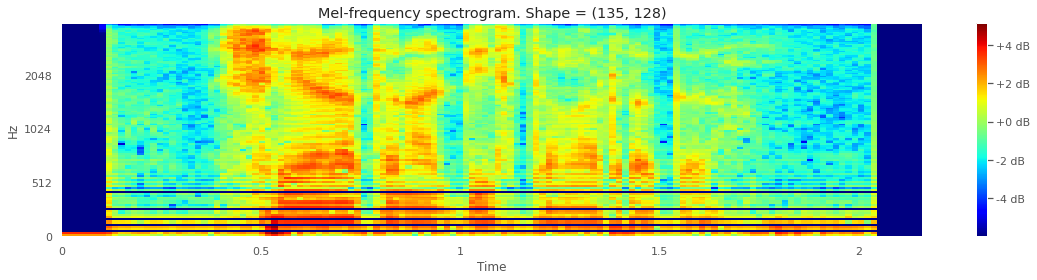



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 35 characters
We have to multiply the longest sentence by 2.6651328494051394 to reach length of Time steps
----------------------------------------------------------------------------------------------------




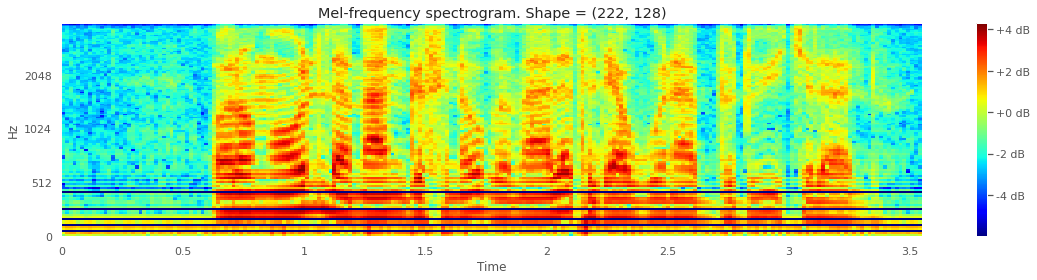



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 48 characters
We have to multiply the longest sentence by 2.4539564885711465 to reach length of Time steps
----------------------------------------------------------------------------------------------------




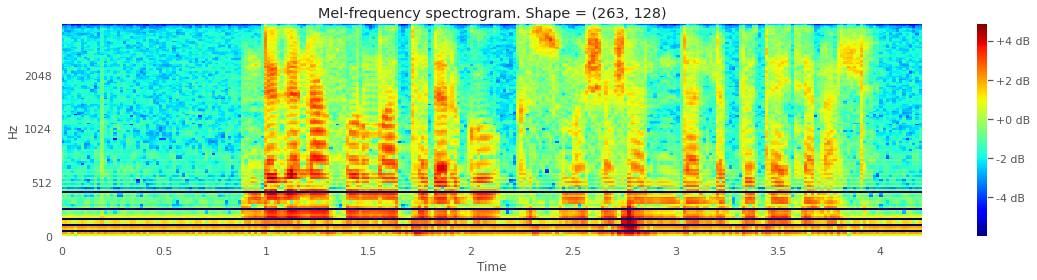



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 53 characters
We have to multiply the longest sentence by 2.5528503155674036 to reach length of Time steps
----------------------------------------------------------------------------------------------------




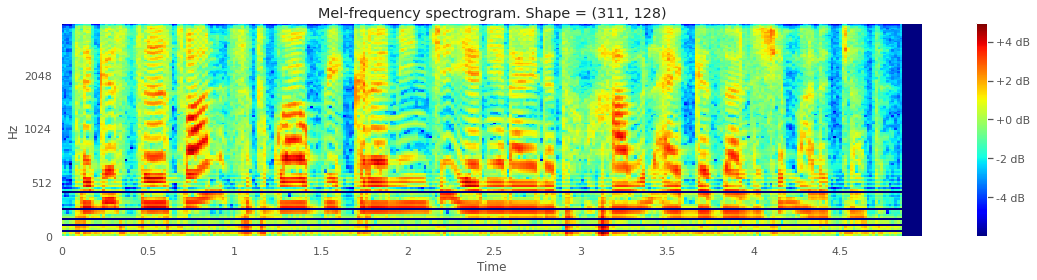



----------------------------------------------------------------------------------------------------
The longest sentence in this batch has 57 characters
We have to multiply the longest sentence by 2.6549500196583096 to reach length of Time steps
----------------------------------------------------------------------------------------------------




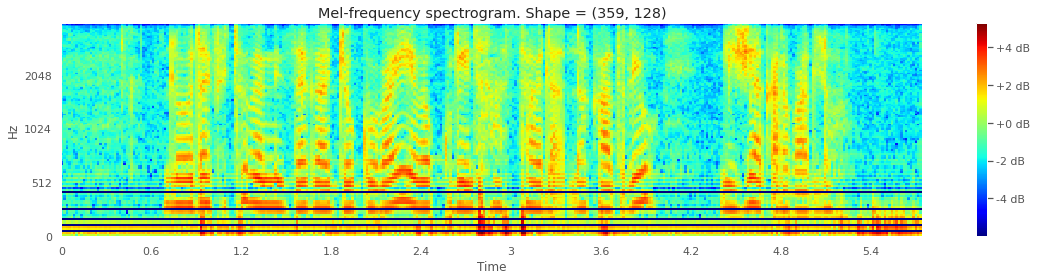

In [ ]:
vis(5)

In [ ]:
melspec = melspecModel.predict(sample_audios)
melspec.shape

(128, 527, 128, 1)

In [ ]:
sample_audios.shape

TensorShape([128, 67584])

In [ ]:
67584/hop_size

528.0

## FINAL DATA

In [ ]:
shuffled_data = shuffle(data)
shuffled_data.head()

,text,char_length,duration,path
2215,ምንም እንኳን ያመሰገኑ ን የውስጥ አዋቂዎች ባይ ጠፉ ም,35,3.97,/content/AMHARIC_CLEAN/train/wav/tr_7084_tr71085.npy
1546,ህዝቡን ሊሰባሰብ የሚችልባቸውን ጥያቄዎች ቀማ,28,3.58,/content/AMHARIC_CLEAN/train/wav/tr_7652_tr77053.npy
6752,የትናንቱም ሆነ የዛሬው የሻእቢያ ወያኔ ግንኙነት በእጅጉ እንደ ጐዳ ቸው በአዲስአበባ ከተማ የሚኖሩ ኤርትራዊያን ገለጹ,74,6.66,/content/AMHARIC_CLEAN/train/wav/tr_6696_tr67097.npy
9434,በዋሽንግተን የጦቢያ ሪፖርተር ወደለንደን ስልክ ደውሎ ይህ ጉዳይ ቀልድ ያየለበት ክስተት እንደሆነ ጠይቆ አንዳንድ ኢትዮጵያውያን የምር ነው ብለዋል,92,9.98,/content/AMHARIC_CLEAN/train/wav/tr_1455_tr15056.npy
6223,ምክንያቱም የመሮጫው ትራክ ይጐዳል በማለት በኢትዮጵያ አትሌቲክስ ፌዴሬሽን ያ መካ ኛል,54,6.27,/content/AMHARIC_CLEAN/train/wav/tr_6499_tr65100.npy


In [ ]:
val_point = int(len(data)*.9)
test_point = int(len(data)*.95)
train_data = shuffled_data[:val_point]
val_data = shuffled_data[val_point:test_point]
test_data = shuffled_data[test_point:]

In [ ]:
train_data = train_data.sort_values("duration")
val_data = val_data.sort_values("duration")
test_data = test_data.sort_values("duration")

In [ ]:
sr = 8000
shuffle = True
batch_size = 32

In [ ]:
train_gen = DataGenerator(train_data, sr, batch_size, shuffle)
val_gen = DataGenerator(val_data, sr, batch_size, shuffle)
test_gen = DataGenerator(test_data, sr, batch_size, shuffle)

In [ ]:
print(f"Size of train data is {len(train_data)} and batch length is {len(train_gen)}")
print(f"Size of valid data is {len(val_data)}  and batch length is {len(val_gen)}")
print(f"Size of test data is {len(test_data)}  and batch length is {len(test_gen)}")

Size of train data is 9606 and batch length is 1200
Size of valid data is 534  and batch length is 66
Size of test data is 534  and batch length is 66


## CTC

In [32]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [33]:
def input_lengths_lambda_func(args):
    input_length = args
    return tf.cast(tf.math.floor(input_length / hop_size)-1, dtype="float32")

In [34]:
x = input_lengths_lambda_func(sample_audios_length[1]).numpy()
x

array([527.], dtype=float32)

In [35]:
def add_ctc_loss(model_builder):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='float32')
    label_lengths = Input(name='label_length', shape=(1,), dtype='float32')

    input_lengths2 = Lambda(input_lengths_lambda_func)(input_lengths)
    if model_builder.output_length:
        output_lengths = Lambda(model_builder.output_length)(input_lengths2)
    else:
        output_lengths = input_lengths2

    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [model_builder.output, the_labels, output_lengths, label_lengths])
    model = Model(inputs=[model_builder.input, the_labels, input_lengths, label_lengths], outputs=loss_out)
    return model

## Model Builder


In [38]:
def build_model(output_dim, custom_model, calc=None):

    input_audios = Input(name='the_input', shape=(None,))
    pre = melspecModel(input_audios)
    pre.trainable = False  # Freeze the layer
    pre = tf.squeeze(pre, [3])

    y_pred = custom_model(pre)
    model = Model(inputs=input_audios, outputs=y_pred, name="model_builder")
    model.output_length = calc

    return model

## Model Trainer

In [39]:
def train(model_builder,
          model_name,
          epochs,
          verbose=1,
          optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          ):

    model = add_ctc_loss(model_builder)

    # optimizer = Adam(lr=.01, clipnorm = 1, decay=1e-6)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
#     print(model.summary())

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath=PATH_Model+model_name+'.h5', verbose=0)
    early_stopping = EarlyStopping( monitor="val_loss", patience=5, restore_best_weights=True)

    # train the model
    hist = model.fit_generator(generator=train_gen,
                               validation_data=val_gen,
                               epochs=epochs,
                               callbacks=[checkpointer, early_stopping],
                               verbose=verbose,
                               use_multiprocessing=False)

    # save model loss
    with open(PATH_Model+model_name+'.pickle', 'wb') as f:
        pickle.dump(hist.history, f)


## Model Inference

In [44]:
from jiwer import wer

In [45]:
def predict(data_gen,  num_elem=1, index=0):
    
    pred_data = data_gen.__getitem__(index)

    pred_audios = pred_data[0]["the_input"]
    pred_labels = pred_data[0]["the_labels"]
    pred_audios_length = pred_data[0]["input_length"]
    
    y_pred = model.predict(pred_audios)

    print("y_pred Shape is: ", y_pred.shape)
    input_shape = tf.keras.backend.shape(y_pred)
    input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(input_shape[1], 'float32')
    prediction = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=False)[0][0]
    print("prediction Shape is: ", prediction.shape)
    print("\n\n")


    for i in range(0, num_elem):  # only on clean data
        
        pred = K.eval(prediction[i]).flatten().tolist()
        pred = list(filter(lambda a: a != -1, pred))

        ground_truth = tokenizer.tokens_to_string(pred_labels[i].numpy())
        hypothesis   = ''.join(tokenizer.tokens_to_string(pred))
        error        = wer(ground_truth, hypothesis)
                
        print('-'*48 + ' ' + str(i) + ' ' + '-'*48)
        print('True transcription:\n' + '\n' + ground_truth)
        print('-'*100)
        print('Predicted transcription:\n' + '\n' + hypothesis)
        print('-'*100)
        print('Word Error Rate:' + str(error))
        print('\n')

## Simple RNN

In [49]:
def simple_rnn_model(input_dim, output_dim=224):

    input_data = Input(name='the_input', shape=(None, input_dim))

    simp_rnn = GRU(output_dim, return_sequences=True, implementation=2, name='rnn')(input_data)

    y_pred = Activation('softmax', name='softmax')(simp_rnn)

    model = Model(inputs=input_data, outputs=y_pred, name="simple_rnn_model")

    model.output_length = lambda x: x

    return model

In [50]:
simple_rnn_model = simple_rnn_model(128, 224)
# plot_model(simple_rnn_model, to_file='../img/simple_rnn_model.png')
simple_rnn_model.summary()

Model: "simple_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 128)]       0         
_________________________________________________________________
rnn (GRU)                    (None, None, 224)         237888    
_________________________________________________________________
softmax (Activation)         (None, None, 224)         0         
Total params: 237,888
Trainable params: 237,888
Non-trainable params: 0
_________________________________________________________________


In [51]:
model = build_model(len(tokenizer.word_index)+2, simple_rnn_model)
model.summary()

Model: "model_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
preprocessin_model (Function (None, None, 128, 1)      512       
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, None, 128)         0         
_________________________________________________________________
simple_rnn_model (Functional (None, None, 224)         237888    
Total params: 238,400
Trainable params: 238,144
Non-trainable params: 256
_________________________________________________________________


In [ ]:
# import mlflow
# mlflow.set_experiment('speech_recognition')
# mlflow.tensorflow.autolog()
train(model_builder=model, model_name="SimpleRNN_model", epochs=25)

## CONV_BRNN

$floor(\frac{n-f+2p}{s}+1) $

In [52]:
def cnn_output_length(input_length, kernel_list, pool_sizes, cnn_stride, mx_stride, padding='valid'):

    if padding == 'same':
        output_length = input_length
        
        return output_length

    elif padding == 'valid':

        output_length = input_length
        for i, j, k in zip(kernel_list, pool_sizes, mx_stride):
            output_length = (output_length - i)/cnn_stride + 1
            if j != 0: output_length = (output_length - j)/k + 1
        
        return tf.math.floor(output_length)

In [53]:
def CONV_BRNN( input_dim, filters, kernels, pool_sizes, mx_stride, cnn_stride, output_dim=224, num_cnn = 3, num_birnn = 4 ):

    input_data = Input(name='the_input', shape=(None, input_dim))
    x = Reshape((-1, input_dim, 1), dtype="float32")(input_data)
    
    for i in range(num_cnn):
        x = Conv2D(filters=filters[i], kernel_size=kernels[i], strides=1, padding='valid', name='cnn_{}'.format(i))(x)
        x = Dropout(.1)(x)
        x = LeakyReLU(.1)(x)
        x = MaxPooling2D( pool_size=pool_sizes[i], strides=(1,2), padding="valid")(x)
        x = BatchNormalization(name='bn_cnn_{}'.format(i))(x)
        
    x = Reshape((-1, x.shape[-1] * x.shape[-2] ))(x)

    for i in range(num_birnn):
        x = Bidirectional(GRU(units=512, return_sequences=True, implementation=2, name='rnn_{}'.format(i)))(x)
        x = Dropout(.2)(x)
        x = LeakyReLU(.1)(x)
        x = BatchNormalization(name='bn_rnn_{}'.format(i))(x)
  
    x = TimeDistributed(Dense(output_dim))(x)

    y_pred = Activation('softmax', name='softmax')(x)

    model = Model( inputs=input_data, outputs=y_pred, name="CONV_BRNN" )

    output_length_calculater = lambda x: cnn_output_length(x, kernels, pool_sizes, cnn_stride, mx_stride)
    
    return model, output_length_calculater

In [54]:
filters = [32, 32, 32]   
kernels = [7, 5, 3] 
pool_sizes = [3, 3, 3]  
mx_stride = [1, 1, 2]
cnn_stride = 1

In [56]:
CONV_BRNN_Model, calc = CONV_BRNN(n_mels, filters, kernels, pool_sizes, mx_stride, cnn_stride)
# plot_model(CONV_BRNN_Model, to_file='../img/CONV_BRNN_Model.png')
CONV_BRNN_Model.summary()

Model: "CONV_BRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 128)]       0         
_________________________________________________________________
reshape_2 (Reshape)          (None, None, 128, 1)      0         
_________________________________________________________________
cnn_0 (Conv2D)               (None, None, 122, 32)     1600      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 122, 32)     0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, None, 122, 32)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, 60, 32)      0         
_________________________________________________________________
bn_cnn_0 (BatchNormalization (None, None, 60, 32)      12

In [57]:
model = build_model(len(tokenizer.word_index)+2, CONV_BRNN_Model, calc)
model.summary()

Model: "model_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
preprocessin_model (Function (None, None, 128, 1)      512       
_________________________________________________________________
tf.compat.v1.squeeze_1 (TFOp (None, None, 128)         0         
_________________________________________________________________
CONV_BRNN (Functional)       (None, None, 224)         17215712  
Total params: 17,216,224
Trainable params: 17,207,584
Non-trainable params: 8,640
_________________________________________________________________


In [ ]:
# import mlflow
# mlflow.set_experiment('speech_recognition')
# mlflow.tensorflow.autolog()
train(model_builder=model, model_name="CONV_BRNN", epochs=25)

## RESNET

In [58]:
def cnn_output_length(input_length, kernel_list, pool_sizes, cnn_stride, mx_stride, padding='same'):

    if padding == 'same':        
        output_length = input_length
        for i, j in zip(cnn_stride, pool_sizes):
            output_length = (output_length)/i
            if j != 0: output_length = (output_length - j)/mx_stride + 1
                
        return tf.math.ceil(output_length)

    elif padding == 'valid':

        output_length = input_length
        for i, j in zip(kernel_list, pool_sizes):
            output_length = (output_length - i)/cnn_stride + 1
            if j != 0: output_length = (output_length - j)/mx_stride + 1
        
        return tf.math.floor(output_length)

In [ ]:
def block(filters, inp):
    inp = inp    
    layer_1 = BatchNormalization()(inp)
    act_1 = Activation('relu')(layer_1)
    conv_1 = Conv2D(filters, (3,3), padding = 'same')(act_1)
    layer_2 = BatchNormalization()(conv_1)
    act_2 = Activation('relu')(layer_2)
    conv_2 = Conv2D(filters, (3,3), padding = 'same')(act_2)
    return(conv_2)

In [ ]:
def resnet( input_dim, output_dim=224, units=256,  number_of_layers=2, activation='tanh', dropout_rate=0.5):

    filters = [16, 32, 64]   
    kernels = [3, 3, 3] 
    pool_sizes = [0, 0, 2]  
    cnn_stride = [1, 1, 1]
    mx_stride = 2


    input_data = Input(name='the_input', shape=(None, input_dim))
    x = Reshape((-1, input_dim, 1), dtype="float32")(input_data)
    
    x = Conv2D(filters[0], (3,3), padding = 'same')(x)
    y = MaxPooling2D((1,2), strides=(1, 2), padding = 'same')(x)
    
    x = Add()([block(filters[0], y),y])  
    y = Add()([block(filters[0], x),x])
    x = Add()([block(filters[0], y),y])

    x = Conv2D(filters[1], (3,3), strides = (1,2), padding = 'same',  activation = 'relu')(x)
    
    y = Add()([block(filters[1], x),x])
    x = Add()([block(filters[1], y),y])
    y = Add()([block(filters[1], x),x])
    
    y = Conv2D(filters[2], (3,3), strides = (1,2), padding = 'same',  activation = 'relu')(y)
    
    x = Add()([block(filters[2], y),y])  
    y = Add()([block(filters[2], x),x])
    x = Add()([block(filters[2], y),y])

    x = MaxPooling2D((2,2), strides=2, padding = 'same')(x)
    # x = AveragePooling2D((2, 2), strides=2, padding='same')(x)
    x = Reshape((-1, x.shape[-1] * x.shape[-2] ))(x)

    layer = GRU(512, activation=activation,  return_sequences=True, implementation=2, name='rnn_1', dropout=dropout_rate)(x)
    layer = BatchNormalization(name='bt_rnn_1')(layer)

    for i in range(number_of_layers - 2):
        layer = GRU(units, activation=activation, return_sequences=True, implementation=2, name='rnn_{}'.format(i+2), dropout=dropout_rate)(layer)
        layer = BatchNormalization(name='bt_rnn_{}'.format(i+2))(layer)

    layer = GRU(512, activation=activation, return_sequences=True, implementation=2, name='final_layer_of_rnn')(layer)
    layer = BatchNormalization(name='bt_rnn_final')(layer)


    time_dense = TimeDistributed(Dense(output_dim))(layer)

    y_pred = Activation('softmax', name='softmax')(time_dense)

    model = Model( inputs=input_data, outputs=y_pred, name="custom_model" )

    output_length_calculater = lambda x: cnn_output_length(x, kernels, pool_sizes, cnn_stride, mx_stride)
    
    return model, output_length_calculater

In [ ]:
resnet, calc = resnet(n_mels, 224, 256, 2, activation='relu')
# plot_model(resnet, to_file= PATH_IMG + 'resnet.png')
resnet.summary()

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, None, 128, 1) 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, 128, 16 160         reshape_2[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, None, 64, 16) 0           conv2d_21[0][0]                  
_______________________________________________________________________________________